In [1]:
from utils import *
from torchvision import datasets, transforms
import torch.utils.data
import matplotlib.pyplot as plt

In [2]:
class VAE(nn.Module):
    """
    Define a Variational Autoencoder (VAE) model.
    """
    def __init__(self, prior, decoder, encoder):
        """
        Parameters:
        prior: [torch.nn.Module]
           The prior distribution over the latent space.
        decoder: [torch.nn.Module]
              The decoder distribution over the data space.
        encoder: [torch.nn.Module]
                The encoder distribution over the latent space.
        """

        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        """
        Compute the ELBO for the given batch of data.

        Parameters:
        x: [torch.Tensor]
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2, ...)`
           n_samples: [int]
           Number of samples to use for the Monte Carlo estimate of the ELBO.
        """
        q = self.encoder(x)
        z = q.rsample()
        elbo = torch.mean(self.decoder(z).log_prob(x) - q.log_prob(z) + self.prior().log_prob(z), dim=0)
        return elbo

    def sample(self, n_samples=1):
        """
        Sample from the model.

        Parameters:
        n_samples: [int]
           Number of samples to generate.
        """
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()

    def forward(self, x):
        """
        Compute the negative ELBO for the given batch of data.

        Parameters:
        x: [torch.Tensor]
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2)`
        """
        return -self.elbo(x)

    def curve_energy(self, C):
        """
        Compute the length of a curve when passed through the decoder mean.

        Parameters:
        C: points along a curve. Dimensions (num_points_along_curve)x(latent_dim)
        """
        lenT, latent_dim = C.shape
        ambient_C = self.decoder(C).mean  # |T| x (data_shape)

        delta = (ambient_C[1:] - ambient_C[:-1])  # (|T|-1) x (data_shape)
        retval = torch.sum(delta.reshape(lenT-1, -1)**2, dim=1).sum(dim=0)  # scalar
        return retval

In [3]:
def subsample(data, targets, num_data, num_classes):
    idx = targets < num_classes
    new_data = data[idx][:num_data].unsqueeze(1).to(torch.float32) / 255
    new_targets = targets[idx][:num_data]

    return torch.utils.data.TensorDataset(new_data, new_targets)

num_train_data = 2048
num_classes = 3
train_tensors = datasets.MNIST('data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_data = subsample(train_tensors.data, train_tensors.targets, num_train_data, num_classes)
mnist_train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)

In [4]:
torch.manual_seed(314159)
M = 2  # latent dimension is two for plotting
prior = GaussianPrior(M)

encoder_net = nn.Sequential(
    nn.Conv2d(1, 16, 3, stride=2, padding=1),
    nn.Softplus(),
    nn.Conv2d(16, 32, 3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(1568, 2*M),
)

def new_decoder():
    decoder_net = nn.Sequential(
        nn.Linear(M, 512),
        nn.Unflatten(-1, (32, 4, 4)),
        nn.Softplus(),
        nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=0),
        nn.Softplus(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.Softplus(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
    )
    return decoder_net

# Define ensemble of VAE models
num_ensembles = 10
models, optimizers = [], []
encoder = GaussianEncoder(encoder_net)
for _ in range(num_ensembles):
    decoder = BernoulliDecoder(new_decoder())
    model = VAE(prior, decoder, encoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    models.append(model)
    optimizers.append(optimizer)

In [5]:
# Run the training loop
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train(models, optimizers, mnist_train_loader, epochs, device)

epoch=99, step=6395, loss=-1248.8: 100%|██████████| 6400/6400 [00:46<00:00, 137.49it/s]


# Now comes the geometry part
So far we have trained a VAE to fit the data. Now we start making identifiable computations in latent space by computing geodesics.

We first define an energy measure that geodesics should minimize. This is merely the squared error, which is averaged across decoders. The latter step ensures that distances are large in regions of latent space where decoders disagree (regions of high model uncertainty). We use a Monte Carlo estimate of the average across decoders.

In [6]:
def ensemble_energy(models, curve):
    num_models = len(models)
    C = curve.points()  # M x (latent_dim)
    M = C.shape[0]
    P = [model.decoder(C).mean.reshape(1, M, -1) for model in models]
    P = torch.concatenate(P, dim=0)  # (num_models) x M x 28²

    rp0 = torch.randperm(num_models)  # (num_models)
    rp1 = torch.randperm(num_models)  # (num_models)

    #p0 = td.Bernoulli(probs = P[rp0, 1:, :])  # (num_models) x (M-1) x 28²
    #p1 = td.Bernoulli(probs = P[rp1, :-1, :])  # (num_models) x (M-1) x 28²
    #E = KL(p0, p1)  # (num_models) x (M-1) x 28²
    E = (P[rp0, 1:, :] - P[rp1, :-1, :])**2
    return E.mean()

In [13]:
## Put trained models in 'eval' mode
for m in range(num_ensembles):
    models[m].eval()

## Encode training data
latents, labels = [], []
with torch.no_grad():
    for x, y in mnist_train_loader:
        x = x.to(device)
        z = models[0].encoder(x)
        latents.append(z.mean)
        labels.append(y)
    latents = torch.concatenate(latents, dim=0)
    labels = torch.concatenate(labels, dim=0)

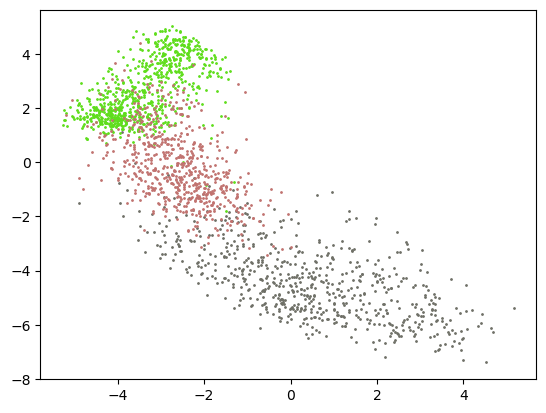

100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


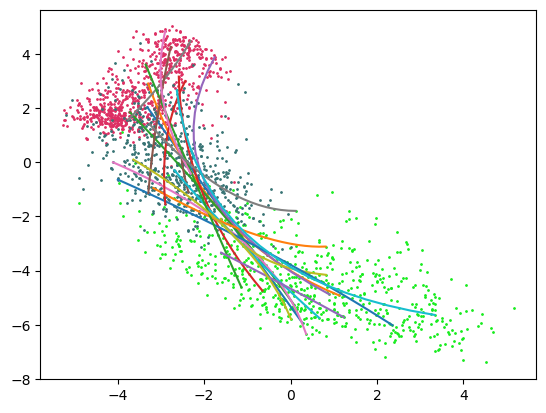

In [17]:
## Plot training data
for k in range(num_classes):
    col = torch.rand(3).numpy()
    idx = labels == k
    plt.scatter(latents[idx, 0].cpu(), latents[idx, 1].cpu(), s=1, color=col)
# Plot random geodesics
num_curves = 20
dm = DensityMetric(latents, 0.5)
dm_energy = lambda model, curve: model.curve_energy(curve.points())
curve_indices = torch.randint(num_train_data, (num_curves, 2))  # (num_curves) x 2
with tqdm(range(num_curves)) as pbar:
    for k in pbar:
        i = curve_indices[k, 0]
        j = curve_indices[k, 1]
        c = Poly2(latents[i], latents[j], 20, device=device)
        connecting_geodesic(dm, c, energy_fun = dm_energy, max_iter = 100)  # initialization
        energy = connecting_geodesic(models, c, energy_fun = ensemble_energy, max_iter = 10, lr = 0.01)  # smaller learning rate as the energy i stochastic
        c.plot('-')